In [1]:
from seagul.rl.ars.ars_pipe import ars
from seagul.nn import MLP
import torch
import matplotlib.pyplot as plt
from seagul.mesh import create_mesh, variation_dim, mesh_dim, create_mesh_dict, BylMesh
import time
import copy
import gym


import xarray as xr
import numpy as np
import pandas as pd

import os

from sklearn.decomposition import PCA

In [2]:
def identity(rews,obs,acts):
    return rews

def vardiv(rews, obs, acts):
    return rews/variation_dim(obs)

def varmul(rews, obs, acts):
    return rews*variation_dim(obs)

def rough_measure(x):
    d = torch.stack([x[t,:] - x[t-1,:] for t in range(1,x.shape[0])])
    return d.std()#$/(torch.abs(d.mean()))

def rmul(rews, obs, acts):
    return rews*rough_measure(obs)

def rdiv(rews, obs, acts):
    return rews/rough_measure(obs)

def pcastd(rews, obs, acts):
    pca = PCA()
    pca.fit((obs - obs.mean())/obs.std())
    return rews*pca.explained_variance_ratio_.std()


def do_rollout(env, policy, render=False):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while not done:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())
        if render:
            env.render()
            input("step?")
            #time.sleep(.05)

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length


def do_long_rollout(env, policy, ep_length):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while cur_step < ep_length:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length

<Figure size 432x288 with 0 Axes>

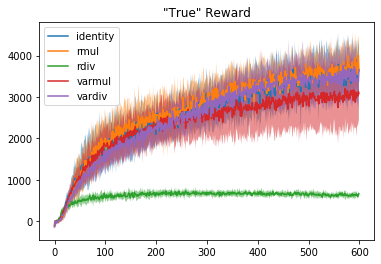

<Figure size 432x288 with 0 Axes>

In [3]:
data = torch.load("./data4/HalfCheetah-v2.xr")

policy_dict = data.policy_dict
rews = data.rews
exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
num_seeds = len(policy_dict['identity'])

#policy_dict = torch.load("./data/mjw_longermul.pol_dict")
#rews = torch.load("./data/mjw_longermul.data")

means = rews.mean(dim="trial")
stds = rews.std(dim="trial")

plt.plot(means.T)
plt.legend(exp_names)
ci = stds

for mean, c in zip(means, ci):
    plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
plt.title("\"True\" Reward")
plt.figure()

# for exp_name in exp_names:  
#     plt.plot(rews.loc[exp_name].T)
#     plt.title(exp_name)
#     plt.figure()

In [4]:
# HalfCheetah-v2
def cheetah_reset(env, point):
    env.reset()
    qpos = np.concatenate((np.array([0.0]), point[:8]))
    qvel = point[8:]
    env.unwrapped.set_state(qpos, qvel)
    return env.unwrapped._get_obs()

def cheetah_snapshot(o, last_o, step):
    return (o[3] > .5 and o[12] < 0.0 and last_o[12] > 0.0 and step > 7)

def cheetah_interp(o, last_o):
    m = o[12] - last_o[12]
    b = last_o[12]
    tcross = -b / m
    return last_o + tcross * (o - last_o)

running build_ext
cycles found:  27.0


<Figure size 432x288 with 0 Axes>

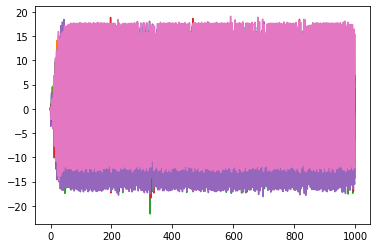

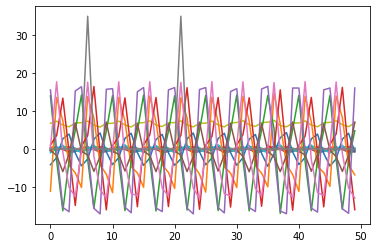

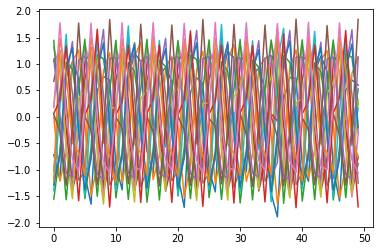

<Figure size 432x288 with 0 Axes>

In [5]:
from sklearn.decomposition import PCA
env_name = "HalfCheetah-v2"

policy = policy_dict['vardiv'][2]
env = gym.make(env_name)
obs,acts,rews,l = do_long_rollout(env, policy, ep_length= 1000)
#o,a,r,l = do_rollout(env, policy, render=True)

on = np.zeros(obs.shape[0])
for i,o in enumerate(obs):
    on[i] = (o[3] > .5 and o[12] < 0.0 and last_o[12] > 0.0)
    last_o = copy.deepcopy(o)

print("cycles found: ", sum(on))

start_idx = 100; end_idx = 150
plt.plot(obs)
plt.figure()
plt.plot(obs[start_idx:end_idx])
plt.plot(on[start_idx:end_idx]*35)
plt.figure()
ref = np.array(obs[start_idx:end_idx],dtype=np.float64)
target = (ref - ref.mean(axis=0))/ref.std(axis=0)
target = copy.deepcopy(target) # Don't even ask
plt.plot(target)
plt.figure()

In [ ]:
#target = np.random.random((500,11))
#target = np.array(o[start_idx:])
pca = PCA(svd_solver='arpack')
pca.fit(target)

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

In [ ]:
pca.singular_values_/pca.singular_values_.max()

In [ ]:
dl = []
last_seen = 0
for i,o in enumerate(on):
    if o == 1:
        dl.append(i-last_seen)
        last_seen = i
        
dd = {}
for d in dl:
    if (d) in dd: 
        dd[(d)] += 1
    else:
        dd[(d)] = 1
        
for thing in dd.items():
    print("spacing: ", thing[0], " frequency: ", thing[1])

In [ ]:
from seagul.mesh import create_mesh_act

perts =  np.random.uniform(-.1,.1,(10,6))
#perts = np.zeros((100,17))

o = env.reset()
last_o = copy.copy(o)

step = 0
done=False
ol = [] 
while not done:
    a = policy(o).detach(); step+=1
    o, r, done, _ = env.step(a.numpy())
    if cheetah_snapshot(o, last_o, step) and step > 100:
        seed_point = o
        done=True
    last_o = copy.copy(o)

print(seed_point)
mesh, mesh_points, T = create_mesh_act(env, policy, .5, seed_point, perts, cheetah_reset, cheetah_snapshot, cheetah_interp, ref.mean(axis=0), ref.std(axis=0))

In [ ]:
failure_point = np.ones_like(seed_point)*10
print(mesh[failure_point].freq)
print(len(mesh))
print(len(mesh_points))

In [ ]:
from scipy import sparse 
Ts = sparse.lil_matrix((T.shape[0], T.shape[0]))
for i,t in enumerate(T):
    #print(i)
    for e in t:
        Ts[i,e-1] += 1/len(t)
    

In [ ]:
w,v = sparse.linalg.eigs(Ts,k=2)

In [ ]:
w

In [ ]:
v.shape

In [ ]:
T